In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import cv2
import multiprocessing
import numpy as np
import random
from tensorflow.keras import backend as K
import time
# import IPython
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2023-05-22 02:37:28.270178: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 02:37:28.306351: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 02:37:28.307013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 02:37:28.845404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0
Num GPUs Available:  0


2023-05-22 02:37:29.679036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 02:37:29.679241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 02:37:29.680722: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

# Load Datasets

In [2]:
def readDataset(image_path):
    num_processes = 16
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_path)
    return results

def process_image(image_path):
    im = cv2.imread(image_path)
    # gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(im, (32, 32), interpolation=cv2.INTER_AREA)
    return resized

def load_dataset(train_image, train_label):
    train_image = readDataset(train_image)
    train_image = np.array(train_image)
    train_image = train_image/float(255)
    train_image -= np.mean(train_image)
    train_label = np.array(train_label)
    return (train_image, train_label)


def read_dataset(img_filename):
    filename = []
    label = []
    with open(img_filename, 'r') as f:
        for line in f.readlines():
            s = line.split(' ')
            filename.append(s[0])
            label.append(int(s[1]))
    dataset = []
    for i in range(len(filename)):
        dataset.append((filename[i],label[i]))   
    random.shuffle(dataset)    
    return dataset

In [3]:
dataset_train = read_dataset('train.txt')
dataset_test = read_dataset('test.txt')
dataset_val  = read_dataset('val.txt')

image_paths_train, Y_train = zip(*dataset_train)
image_paths_test, Y_test = zip(*dataset_test)
image_paths_val, Y_val = zip(*dataset_val)

(x_train, y_train) = load_dataset(image_paths_train, Y_train)
(x_test, y_test)   = load_dataset(image_paths_test, Y_test)
(x_valid, y_valid) = load_dataset(image_paths_val, Y_val)

In [4]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test  = tf.convert_to_tensor(x_test,  dtype=tf.float32)
x_valid = tf.convert_to_tensor(x_valid, dtype=tf.float32)
x_train.shape

TensorShape([63325, 32, 32, 3])

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=x_train.shape[1:]))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(16, 5, activation='tanh'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(120, 5, activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(50, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 activation_1 (Activation)   (None, 5, 5, 16)          0

In [6]:
start_time = time.time()

# compile and fit your model
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=2048, epochs=30, validation_data=(x_valid, y_valid))

end_time = time.time()

# calculate the total training time
total_time = end_time - start_time

# calculate the average time per epoch
avg_time_per_epoch = total_time / len(history.history['loss'])

print(f'Total training time: {total_time:.2f} seconds')
print(f'Average time per epoch: {avg_time_per_epoch:.2f} seconds')

Epoch 1/10
31/31 [==============================] - 4s 110ms/step - loss: 3.9230 - accuracy: 0.0205 - val_loss: 3.9240 - val_accuracy: 0.0200
Epoch 2/10
31/31 [==============================] - 3s 105ms/step - loss: 3.9143 - accuracy: 0.0207 - val_loss: 3.9180 - val_accuracy: 0.0156
Epoch 3/10
31/31 [==============================] - 3s 102ms/step - loss: 3.9078 - accuracy: 0.0230 - val_loss: 3.9026 - val_accuracy: 0.0444
Epoch 4/10
31/31 [==============================] - 3s 104ms/step - loss: 3.8514 - accuracy: 0.0353 - val_loss: 3.8139 - val_accuracy: 0.0422
Epoch 5/10
31/31 [==============================] - 3s 101ms/step - loss: 3.7724 - accuracy: 0.0468 - val_loss: 3.7457 - val_accuracy: 0.0600
Epoch 6/10
31/31 [==============================] - 3s 105ms/step - loss: 3.7426 - accuracy: 0.0537 - val_loss: 3.7143 - val_accuracy: 0.0644
Epoch 7/10
31/31 [==============================] - 3s 103ms/step - loss: 3.7202 - accuracy: 0.0589 - val_loss: 3.6841 - val_accuracy: 0.0867
Epoch 

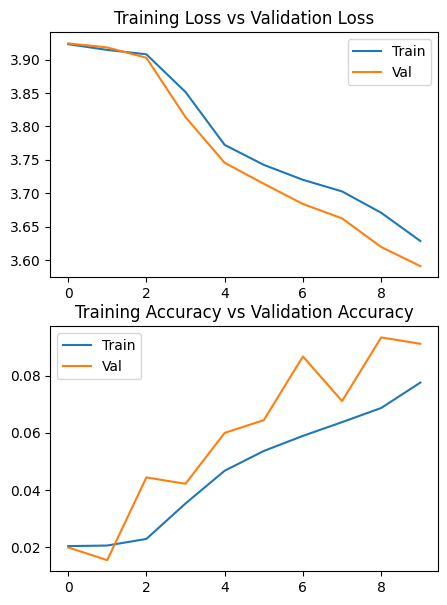

In [11]:
f = plt.figure(figsize=(4,6), dpi=100)
ax = f.add_subplot(211)
plt.title("TensorFlow")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("Loss")
plt.xticks([])
plt.legend(['Train', 'Valid'])

ax = f.add_subplot(212)
plt.plot(np.array(history.history['accuracy'])*100)
plt.plot(np.array(history.history['val_accuracy'])*100)
# plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim([0, 14])

plt.savefig('./pic/lenet5_tf.png')

In [10]:
from keras_flops import get_flops
# Calculae FLOPS
flops = get_flops(model)
print(f"FLOPS: {flops / 10e6} G")


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

2023-05-22 02:40:13.685509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 02:40:13.685748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 02:40:13.685894: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-05-22 02:40:13.685956: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-22 02:40:13.686252: I tensorflow/compiler/xla/stream_executor/

In [9]:
start_time = time.time()
model.evaluate(x_test, y_test, batch_size=64)
end_time = time.time()
# calculate the total training time
total_time = end_time - start_time
print(total_time)

15/15 [==============================] - 0s 2ms/step - loss: 3.5939 - accuracy: 0.0889
0.07089900970458984
